In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn

run_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/transformer_testing_output"

time_stamp_dfs = {"training_log" : None}
run_loss_dataframes = {}
for sub in os.listdir(run_output_dir):
    subpath = os.path.join(run_output_dir, sub)
    if sub.startswith("model_training") and os.path.isdir(subpath) and len(os.listdir(subpath)) > 0:
        time_stamp = "_".join([i for i in sub.split("_")[2:]])
        print(time_stamp)
        time_stamp_dfs[time_stamp] = {}
        
        training_log_file = os.path.join(subpath, "training_log.csv")
        if os.path.isfile(training_log_file):
            training_log_df = pd.read_csv(training_log_file, header=0, index_col=0)
            # print(training_log_df.head())
            
            
            time_stamp_dfs[time_stamp]["training_log"] = training_log_df
            


25_09_11_23_45
25_09_13_45_40
250925100053
25_09_13_48_09
25_09_12_51_00
25_09_11_52_57


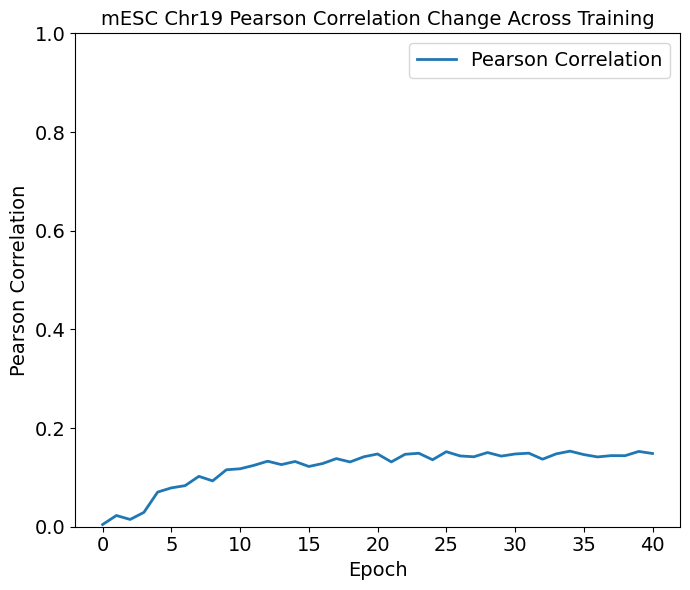

In [29]:
def plot_pearson_corr_across_epochs(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title("mESC Chr19 Pearson Correlation Change Across Training", fontsize=14)
    plt.ylim((0,1))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Pearson Correlation", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig

df = time_stamp_dfs["25_09_13_48_09"]["training_log"]
fig = plot_pearson_corr_across_epochs(df)
fig.show()

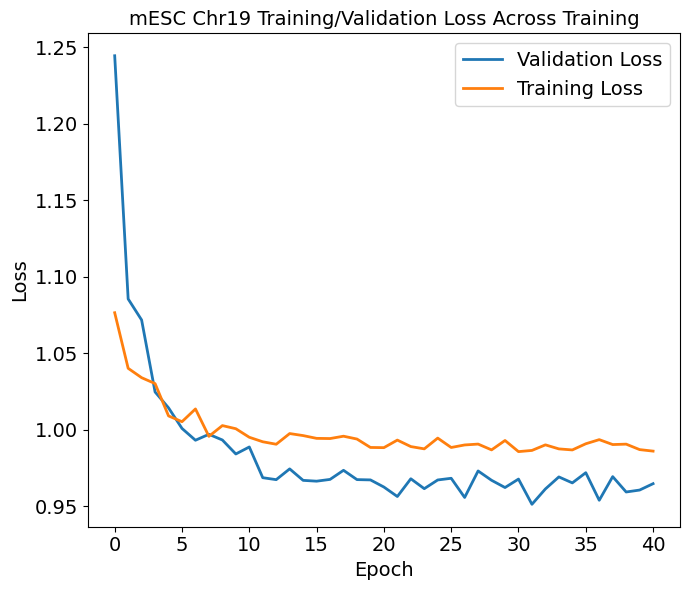

In [28]:
def plot_train_val_loss(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Train Loss"], linewidth=2, label="Validation Loss")
    plt.plot(df.index, df["Val Loss"], linewidth=2, label="Training Loss")

    plt.title("mESC Chr19 Training/Validation Loss Across Training", fontsize=14)
    # plt.ylim((0,1))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig
    
fig = plot_train_val_loss(df)
fig.show()